### Fix scaling for O2 and methane

O2 has a profile that decreases with depth and the scaling underestimates the amount of O2 that get on the shelf. Methane has a large curvature and a large gradient below shelf break depth and the model overestimates the amount of methane that is upwelled onto the shelf.


In [56]:
import cmocean as cmo
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns
from netCDF4 import Dataset
import xarray as xr

import os
import sys

import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

sns.set_context('notebook')

In [57]:
# CONSTANTS AND SCALES

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3 # Initial stratification at shelf-break depth
f = 9.66E-5 # Coriois parameter 
kv = 1E-5   # base case background vertical diffusivity
kbg = 1E-5  # base case canyon vertical diffusivity
t = 6.5 # diffusion timescale, days 
U = 0.36 # incoming velocity base case, m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [58]:
# SCALING SCHEME (WITH DIMENSIONS)

def Cbar(grad, Hs, Hr, Co):
    '''
    INPUT
    grad :float: Scaled tracer gradient [C]/m
    Hs: float: Shelf-break depth (m)
    Hr: float: Rim depth (m)
    Co: float: Initial concentration near shelf break [C]
    RETURNS 
    approx concentration of upwelled water. See equation 26 in paper 1
    '''
    #return(((0.01*(abs(grad)*(Hs+Hr)/2.0))+1.0)*Co)
    return(((0.01*(grad*(Hs+Hr)/2.0))+1.0)*Co)

def Cbar_below(grad, Hs, Hr, Co):
    '''
    INPUT
    grad :float: Scaled tracer gradient [C]/m
    Hs: float: Shelf-break depth (m)
    Hr: float: Rim depth (m)
    Co: float: Initial concentration near shelf break [C]
    RETURNS 
    approx concentration of upwelled water. See equation 26 in paper 1
    '''
    return(((0.01*(grad*(Hs+Hr)/2.0))+1.03)*Co)

def dTrdz(dTr0, Hs, Zup, Zdifup, Hh):
    '''
    INPUT
    dTr0: float: Initial tracer gradient near shelf break [C]/m
    Zup: float: depth of upwelling (m)
    Zdifup: float: squeezing effect due to locally enchanced diffusivity (m)
    Hh: float: Head depth (m)
    RETURNS
    dTrdz: float: Scaled tracer gradient near canyon head. See equation 22.
    '''
    return(-(dTr0)*(4.17*(1+((Zup+Zdifup)/Hh))-3.25))
    
def dTrdz_below(dTr0, Hs, Zup, Zdifup, Hh):
    '''
    INPUT
    dTr0: float: Initial tracer gradient near shelf break [C]/m
    Zup: float: depth of upwelling (m)
    Zdifup: float: squeezing effect due to locally enchanced diffusivity (m)
    Hh: float: Head depth (m)
    RETURNS
    dTrdz: float: Scaled tracer gradient near canyon head. See equation 22.
    '''
    return((dTr0)*(3.97*(1+((Zup+Zdifup)/Hh))-2.33))

def PhiHA(s, N, U, f, W, L):
    '''
    INPUT
    s: float: shelf slope
    N: float: initial stratification
    U: float: incomming velocity
    W: float: Mid-length width of the canyon
    L: float: Canyon length
    f: float: Coriolis Parameter
    RETURNS
     Upwelling flux: float: as calculated by Howatt and Allen, 2013.
    '''
    Se = (s*N)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
    return((U*W*Dh(f,L,N))*(0.91*((F(Ro(U,f,W))**(1.5))*(Ro(U,f,L)**(0.5))*((1-(1.21*Se))**3))+0.07))
    #return((U*W*Dh(f,L,N))*(5*((F(Ro(U,f,W))**(1.5))*(Ro(U,f,L)**(0.5))*((1-(1.21*Se))**3))+0.01))

def PhiTr(Phi, Capprox):
    '''
    INPUT
    Phi: float: upwelling flux as calulated by Howatt adn Allen, 2013. Function PhiHA.
    Capprox: float: Approx concentration of upwelled water. Function Cbar.
    RETURNS
     Tracer flux upwelled onto the shelf: flux: Phi*Capprox.
    '''
    return(Phi*Capprox)
    
def Z(f, U, R, L, N):
    '''
    INPUT
    U: float: incomming velocity
    R: float: Radius of curvature shelf-break isobath
    f: float: Coriolis Parameter
    L: float: Canyon length
    N: float: initial stratification
    RETURNS
    Depth of upwelling from Allen and Hickey, 2010.
    '''
    return(((f*U*F(Ro(U,f,R))*L)**(0.5))/N)

def Zdif(t, kv, kbg):
    '''
    INPUT
    t : float: timescale for upwelling (sec)
    kv: float: vertical diffusivity within the canyon
    kbg: float: background vertical diffusivity
    RETURNS
    Zdif: float: squeezing effect due to locally enchanced diffusivity (m)
    '''
    return(np.sqrt(t*3600*24*(kv-kbg)))


In [59]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

import canyon_records_tracers
recordsTr = canyon_records_tracers.main()

In [60]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_file_parab = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

times = state.variables['T']
depth = grid.variables['RC']

fileBAR = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run01.csv')
fileLWRNoC = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [61]:
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitO','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['tan','0.2','beige','0.4','0.5','brown','0.7'] 
sizes_Para = [11,7,7,7,7,7,7] 

In [62]:
# Get tracer gradient and tracer concetration of all runs
#------------------------------------------------------------------------------------------------------------
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_maxTr = np.empty(8)
Bar_stdTr = np.empty(8)
Bar_TrSB = np.empty(8)
Bar_Ctop = np.empty(8)

Par_maxTr = np.empty(7)
Par_stdTr = np.empty(7)
Par_TrSB = np.empty(7)
Par_Ctop = np.empty(7)

record = recordsTr[0]
ii = 0

for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
    
    
    Bar_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_TrSB[ii] = maxd0
    Bar_Ctop[ii] = df[key0][0]
    ii=ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
   
    
    Par_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_TrSB[ii] = maxd0
    Par_Ctop[ii] = df[key0][0]
    ii=ii+1

#------------------------------------------------------------------------------------------------------------
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_dTrdz = np.empty(8)
Bar_inidTrdz = np.empty(8)
Bar_inidTrdz_head = np.empty(8)
Bar_inidTrdz_rim = np.empty(8)
Bar_inidTrdz_below = np.empty(8)

Bar_dTrdz_std = np.empty(8)
       
Par_dTrdz = np.empty(7)
Par_inidTrdz = np.empty(7)
Par_dTrdz_std = np.empty(8)
Par_inidTrdz_head = np.empty(8)
Par_inidTrdz_rim = np.empty(8)
Par_inidTrdz_below = np.empty(8)

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
    Bar_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Bar_inidTrdz[ii] = df[key0][30]
    Bar_inidTrdz_head[ii] = df[key0][22]
    Bar_inidTrdz_rim[ii] = df[key0][26]
    Bar_inidTrdz_below[ii] = df[key0][33]
    
    Bar_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    ii = ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
 
    Par_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Par_inidTrdz[ii] = df[key0][30]
    Par_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Par_inidTrdz_head[ii] = df[key0][22]
    Par_inidTrdz_rim[ii] = df[key0][26]
    Par_inidTrdz_below[ii] = df[key0][33]
    
    ii = ii+1    



In [63]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']

In [64]:
def scale_PhiTr(dTr0, Cini, Hs, f, U, R, L, N, t, kv, kbg, Hh, Hr, W ):
    ''''''
    dTr_scaled = dTrdz(dTr0, Hs, Z(f, U, R, L, N), Zdif(t, kv, kbg), Hh)
    Capprox = Cbar(dTr_scaled, Hs, Hr, Cini)
    HA = PhiHA(s, N, U, f, W, L)
    return(PhiTr(HA,Capprox), Capprox)

def scale_PhiTr_Co(dTr0, Cini, Hs, f, U, R, L, N, t, kv, kbg, Hh, Hr, W ):
    ''''''
    HA = PhiHA(s, N, U, f, W, L)
    return(PhiTr(HA,Cini), Cini)

def model_PhiTr(mass_can_eff, time):
    ''''''
    PhiTracer = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    return(PhiTracer, PhiTr_std)

def model_Phi(hcw_can_eff, time):
    ''''''
    Phi = np.mean(np.array([(hcw_can_eff[ii]-hcw_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(hcw_can_eff[ii]-hcw_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    return(Phi, Phi_std)

## Original scaling from paper 1

Tracer	Phi err (%)	C err (%)	dTr0		 TrSB
Tr1 	3.8		14.7		0.050		13.6
Tr2 	1.0		10.3		0.059		13.6
Tr3 	3.3		13.9		0.051		13.6
Tr4 	4.3		15.4		0.049		13.6
Tr5 	6.6		18.9		0.043		13.6
Tr6 	11.5		6.3		0.113		13.6
Tr7 	14.0		1.5		-0.013		150.1
Lin 	5.4		0.7		0.002		32.2
Sal 	5.2		0.5		0.001		33.9
Oxy 	87.4		87.6		-0.186		104.1
Nit 	18.6		12.1		0.031		32.6
Sil 	26.5		18.6		0.047		47.6
Pho 	4.4		1.2		0.001		2.2
NitO 	12.5		6.2		0.007		27.7
Met 	115.2		94.9		0.375		17.5


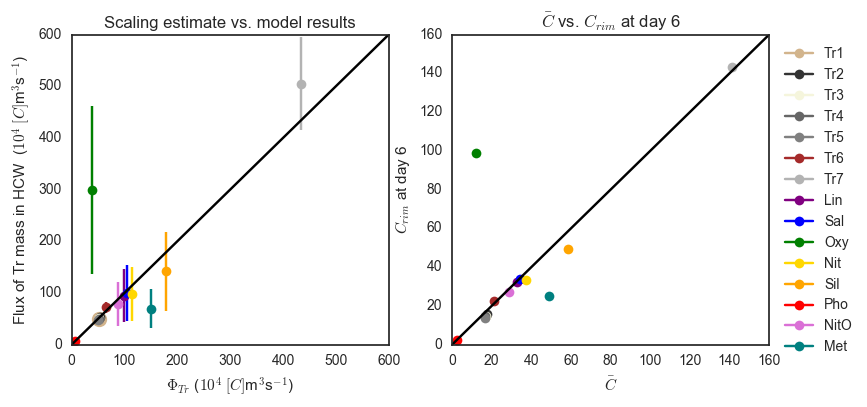

In [65]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', '\t TrSB']))

rec = recordsTr[0]

for TrMass, dTr0,Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz,Par_TrSB,Par_maxTr,labels_Para,colours_Para,
                                           sizes_Para):
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, modPhiTr_std = model_PhiTr(dfLWR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, -dTr0, Co)]))
    

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C

    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100,
                                                                            abs(1-err_C)*100,
                                                                            -dTr0,
                                                                            Co)]))
   
 
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Flux of Tr mass in HCW  ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
ax1.plot(np.linspace(0,600,50),np.linspace(0,600,50),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.linspace(0,160,50),np.linspace(0,160,50),'-k')

Tracer e_hd (%) e_rim (%) e_sb (%) e_ bel(%) -dTr0 hd -dTr0 rim -dTr0 sb -dTr0 bel -dTr model
Tr1 	6.5	6.464	6.464	6.464		0.050	0.050	0.050	0.050		0.159
Tr2 	2.4	44.180	90.731	137.282		0.030	0.045	0.059	0.073		0.105
Tr3 	7.5	12.934	18.360	23.787		0.047	0.049	0.051	0.054		0.147
Tr4 	5.7	1.424	2.810	7.043		0.053	0.051	0.049	0.047		0.170
Tr5 	3.5	20.478	37.450	54.423		0.066	0.054	0.043	0.031		0.232
Tr6 	17.1	116.726	250.533	384.340		-0.087	0.013	0.113	0.212		-0.253
Tr7 	33.8	69.117	104.412	139.707		0.188	0.087	-0.013	-0.113		0.960
Lin 	6.4	6.392	6.416	6.404		0.002	0.002	0.002	0.002		0.005
Sal 	70.7	70.709	89.964	92.218		0.003	0.003	0.001	0.001		0.034
Oxy 	66.5	66.487	83.854	54.925		-0.386	-0.386	-0.186	-0.520		-3.908
Nit 	83.5	83.543	88.377	78.849		0.044	0.044	0.031	0.057		0.908
Sil 	61.6	61.586	85.163	58.404		0.122	0.122	0.047	0.132		1.079
Pho 	70.2	70.160	31.154	118.032		0.003	0.003	0.001	0.004		0.006
NitO 	5.7	5.662	91.882	91.882		0.087	0.087	0.007	0.007		0.280
Met 	40.9	40.904	116.973

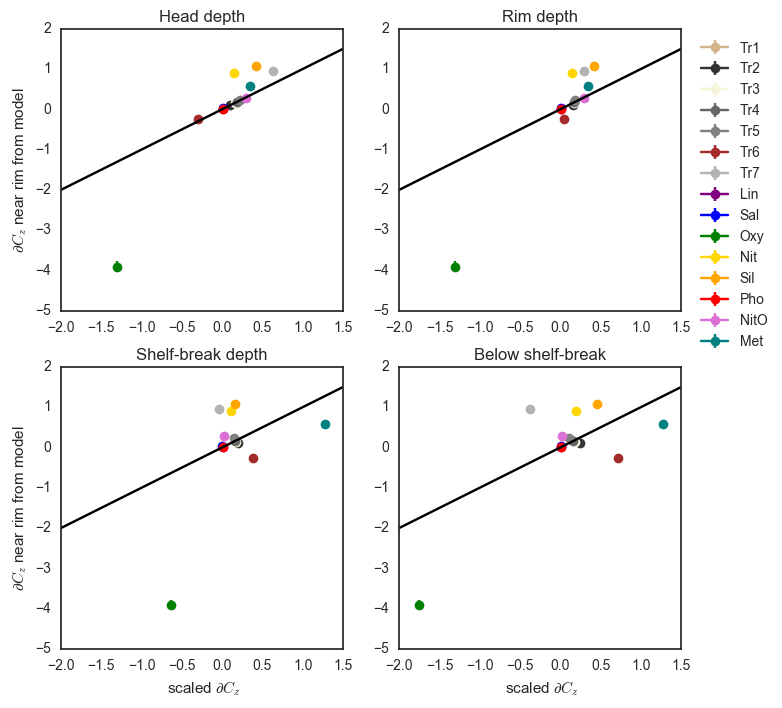

In [66]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

print (" ".join(['Tracer','e_hd (%)', 'e_rim (%)','e_sb (%)','e_ bel(%)',
                  '-dTr0 hd','-dTr0 rim','-dTr0 sb','-dTr0 bel','-dTr model']))

rec = recordsTr[0]

for dTr0, dTr0head, dTr0rim, dTr0below, dTr_mod, std, lab, col in zip(Par_inidTrdz,
                                                                      Par_inidTrdz_head,
                                                                      Par_inidTrdz_rim,
                                                                      Par_inidTrdz_below,
                                                                      Par_dTrdz,
                                                                      Par_dTrdz_std,
                                                                      labels_Para,
                                                                      colours_Para):
    
    dTr_scaled = dTrdz(dTr0, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_head = dTrdz(dTr0head, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_rim = dTrdz(dTr0rim, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_below = dTrdz(dTr0below, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    
    ax3.errorbar(dTr_scaled, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax1.errorbar(dTr_scaled_head, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(dTr_scaled_rim, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax4.errorbar(dTr_scaled_below, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    
    err_sb = dTr_scaled/(-dTr_mod)
    err_head = dTr_scaled_head/(-dTr_mod)
    err_rim = dTr_scaled_rim/(-dTr_mod)
    err_below = dTr_scaled_below/(-dTr_mod)
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f' %
                                    (abs(1-err_head)*100,abs(1-err_rim)*100,abs(1-err_sb)*100,abs(1-err_below)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below,-dTr_mod)]))

for dTr0, dTr0head, dTr0rim, dTr0below, dTr_mod,std, lab, col in zip(Bar_inidTrdz,
                                                                     Bar_inidTrdz_head,
                                                                     Bar_inidTrdz_rim,
                                                                     Bar_inidTrdz_below,
                                                                     Bar_dTrdz,
                                                                     Bar_dTrdz_std,
                                                                     labels_Bark,
                                                                     colours_Bark):
    
    dTr_scaled = dTrdz(dTr0, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_head = dTrdz(dTr0head, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_rim = dTrdz(dTr0rim, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    dTr_scaled_below = dTrdz(dTr0below, Hs, Z(f, U, R, L, No), Zdif(t, kv, kbg), Hh)
    
    ax3.errorbar(dTr_scaled, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax1.errorbar(dTr_scaled_head, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(dTr_scaled_rim, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
    ax4.errorbar(dTr_scaled_below, -dTr_mod, yerr=std, color=col, label=lab, marker='o')
   
    err_sb = dTr_scaled/(-dTr_mod)
    err_head = dTr_scaled_head/(-dTr_mod)
    err_rim = dTr_scaled_rim/(-dTr_mod)
    err_below = dTr_scaled_below/(-dTr_mod)
    
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f' %
                                    (abs(1-err_head)*100,abs(1-err_rim)*100,abs(1-err_sb)*100,abs(1-err_below)*100,
                                     -dTr0head,-dTr0rim,-dTr0,-dTr0below,-dTr_mod)]))

ax3.set_xlabel(r' scaled $\partial C_z$')
ax4.set_xlabel(r' scaled $\partial C_z$')

ax1.set_ylabel(r'$\partial C_z$ near rim from model')
ax3.set_ylabel(r'$\partial C_z$ near rim from model')

ax3.set_title('Shelf-break depth')
ax1.set_title('Head depth')
ax2.set_title('Rim depth')
ax4.set_title('Below shelf-break')
ax1.plot(np.linspace(-2.0,1.5,50),np.linspace(-2,1.5,50),'-k')
ax2.plot(np.linspace(-2.0,1.5,50),np.linspace(-2,1.5,50),'-k')
ax3.plot(np.linspace(-2.0,1.5,50),np.linspace(-2,1.5,50),'-k')
ax4.plot(np.linspace(-2.0,1.5,50),np.linspace(-2,1.5,50),'-k')

ax1.set_xlim(-2,1.5)
ax2.set_xlim(-2,1.5)
ax3.set_xlim(-2,1.5)
ax4.set_xlim(-2,1.5)

ax2.legend(bbox_to_anchor=(1.35,1),ncol=1, columnspacing=0.1)


Using the rim depth initial gradients greatly improves the scaling for the tracer gradient (See table above the 4 panel figure) for salinity, oxygen, silicate, nitrous acid and methane. Using the head depth initial gradient improves not only those 5 tracers but also tr7, tr6, tr5, tr3, tr2. On the other hand, Tr4 and phospate have a larger error when using the head depth from (tr4 1.4% to 5.6% and phosphate from 31.2% to 70%). I also tried initial gradient values at shallower depths than the head ans some of the improved ones got worse.

### Tracer mass and concetration scaling with dTr0 taken at canyon head depth

Tracer C err_hd (%) C err_rim (%) C err_sb (%) C err_ bel(%) -dTr0 hd -dTr0 rim -dTr0 sb -dTr0 bel -dTr model
Tr1 	14.7	14.720	14.720	14.720		0.050	0.050	0.050	0.050
Tr2 	1.5	4.415	10.295	16.174		0.030	0.045	0.059	0.073
Tr3 	11.9	12.911	13.935	14.959		0.047	0.049	0.051	0.054
Tr4 	17.3	16.385	15.443	14.501		0.053	0.051	0.049	0.047
Tr5 	29.7	24.307	18.875	13.444		0.066	0.054	0.043	0.031
Tr6 	64.2	35.260	6.311	22.638		-0.087	0.013	0.113	0.212
Tr7 	97.6	48.047	1.528	51.103		0.188	0.087	-0.013	-0.113
Lin 	0.7	0.685	0.685	0.685		0.002	0.002	0.002	0.002
Sal 	1.4	1.416	0.504	0.397		0.003	0.003	0.001	0.001
Oxy 	187.5	187.459	87.560	253.974		-0.386	-0.386	-0.186	-0.520
Nit 	18.1	18.120	12.128	23.939		0.044	0.044	0.031	0.057
Sil 	53.0	53.012	18.564	57.662		0.122	0.122	0.047	0.132
Pho 	0.3	0.307	1.186	0.109		0.003	0.003	0.001	0.004
NitO 	45.5	45.493	6.222	6.222		0.087	0.087	0.007	0.007
Met 	4.1	4.134	94.908	94.908		0.102	0.102	0.375	0.375


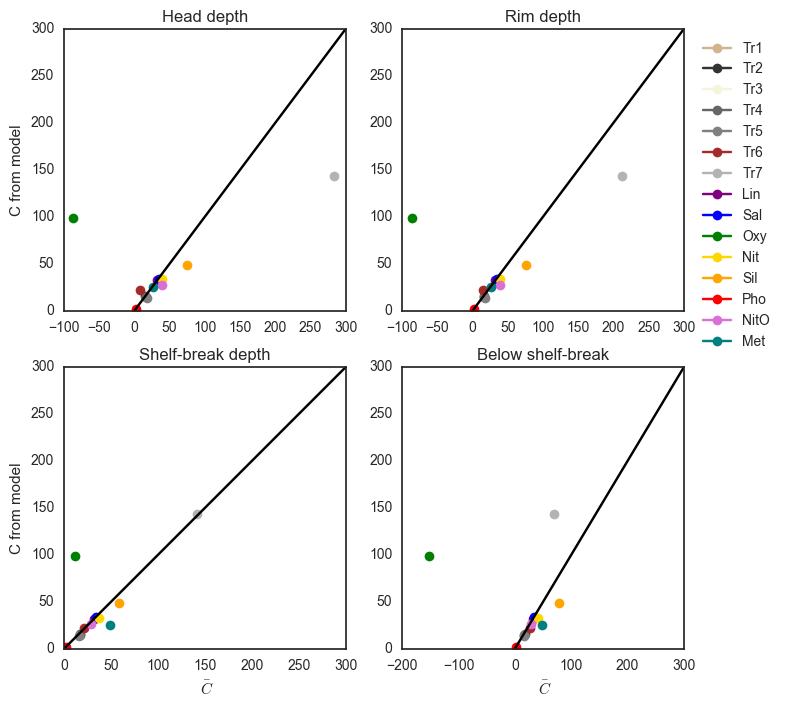

In [67]:
fig1,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

print (" ".join(['Tracer','C err_hd (%)', 'C err_rim (%)','C err_sb (%)','C err_ bel(%)',
                  '-dTr0 hd','-dTr0 rim','-dTr0 sb','-dTr0 bel','-dTr model']))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz,
                                                                          Par_inidTrdz_head,
                                                                          Par_inidTrdz_rim,
                                                                          Par_inidTrdz_below,
                                                                          Par_TrSB,Par_maxTr,
                                                                          labels_Para,colours_Para, sizes_Para):
    scaPhiTr_hd, CC_hd = scale_PhiTr(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC_rm = scale_PhiTr(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC_sb = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC_bl = scale_PhiTr(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    ax1.plot(CC_hd, C, color=col, label=lab, marker='o')
    ax2.plot(CC_rm, C, color=col, label=lab, marker='o')
    ax3.plot(CC_sb, C, color=col, label=lab, marker='o')
    ax4.plot(CC_bl, C, color=col, label=lab, marker='o')
    
    err_hd = CC_hd/C
    err_rm = CC_rm/C
    err_sb = CC_sb/C
    err_bl = CC_bl/C

    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,
                                                                      Bar_inidTrdz_head,
                                                                      Bar_inidTrdz_rim,
                                                                      Bar_inidTrdz_below,
                                                                      Bar_TrSB,Bar_maxTr,
                                                                      labels_Bark,colours_Bark):
    
    scaPhiTr_hd, CC_hd = scale_PhiTr(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC_rm = scale_PhiTr(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC_sb = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC_bl = scale_PhiTr(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    ax1.plot(CC_hd, C, color=col, label=lab, marker='o')
    ax2.plot(CC_rm, C, color=col, label=lab, marker='o')
    ax3.plot(CC_sb, C, color=col, label=lab, marker='o')
    ax4.plot(CC_bl, C, color=col, label=lab, marker='o')
    
    err_hd = CC_hd/C
    err_rm = CC_rm/C
    err_sb = CC_sb/C
    err_bl = CC_bl/C

    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

ax3.set_xlabel(r' $\bar{C}$')
ax4.set_xlabel(r' $\bar{C}$')
ax1.set_ylabel(r'C from model')
ax3.set_ylabel(r'C from model')

ax3.set_title('Shelf-break depth')
ax1.set_title('Head depth')
ax2.set_title('Rim depth')
ax4.set_title('Below shelf-break')
ax1.plot(np.linspace(0,300,50),np.linspace(0,300,50),'-k')
ax2.plot(np.linspace(0,300,50),np.linspace(0,300,50),'-k')
ax3.plot(np.linspace(0,300,50),np.linspace(0,300,50),'-k')
ax4.plot(np.linspace(0,300,50),np.linspace(0,300,50),'-k')

#ax1.set_xlim(-2,1.5)
#ax2.set_xlim(-2,1.5)
#ax3.set_xlim(-2,1.5)
#ax4.set_xlim(-2,1.5)

ax2.legend(bbox_to_anchor=(1.35,1),ncol=1, columnspacing=0.1)

Tracer PhiTrErr_hd (%) PhiTrErr_rim (%) PhiTrErr_sb (%) PhiTrErr_ bel(%) -dTr0 hd -dTr0 rim -dTr0 sb -dTr0 bel -dTr model
Tr1 	3.8	3.784	3.784	3.784		0.050	0.050	0.050	0.050
Tr2 	9.7	4.337	1.049	6.436		0.030	0.045	0.059	0.073
Tr3 	1.4	2.329	3.256	4.184		0.047	0.049	0.051	0.054
Tr4 	6.0	5.127	4.276	3.425		0.053	0.051	0.049	0.047
Tr5 	16.3	11.477	6.606	1.735		0.066	0.054	0.043	0.031
Tr6 	66.2	38.814	11.454	15.906		-0.087	0.013	0.113	0.212
Tr7 	72.5	29.242	14.036	57.314		0.188	0.087	-0.013	-0.113
Lin 	5.4	5.402	5.402	5.402		0.002	0.002	0.002	0.002
Sal 	6.2	6.174	5.220	5.108		0.003	0.003	0.001	0.001
Oxy 	188.8	188.828	87.365	256.384		-0.386	-0.386	-0.186	-0.520
Nit 	25.0	24.970	18.631	31.127		0.044	0.044	0.031	0.057
Sil 	63.2	63.206	26.463	68.165		0.122	0.122	0.047	0.132
Pho 	5.4	5.362	4.433	5.801		0.003	0.003	0.001	0.004
NitO 	54.0	54.030	12.455	12.455		0.087	0.087	0.007	0.007
Met 	15.0	14.987	115.220	115.220		0.102	0.102	0.375	0.375


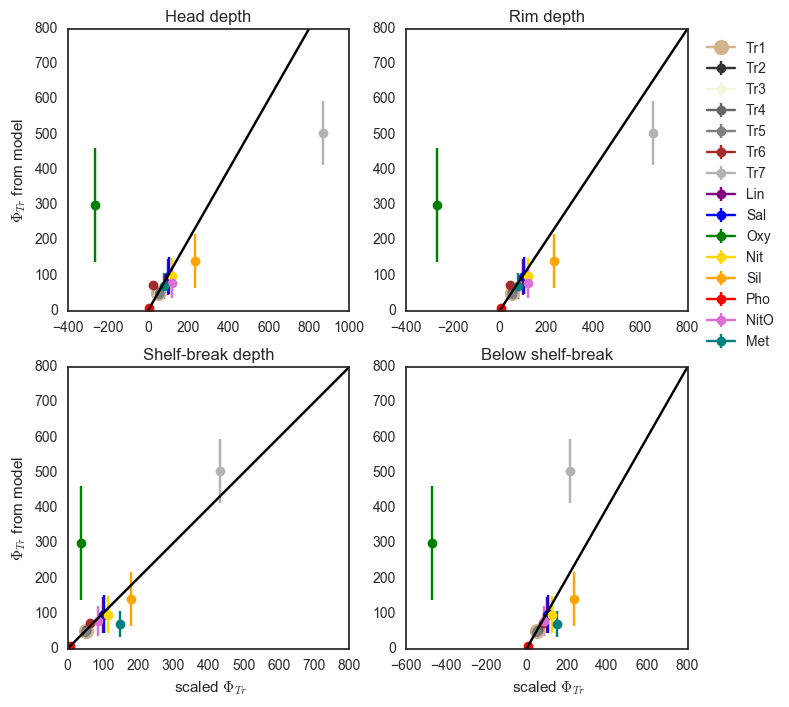

In [68]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

print (" ".join(['Tracer','PhiTrErr_hd (%)', 'PhiTrErr_rim (%)','PhiTrErr_sb (%)','PhiTrErr_ bel(%)',
                  '-dTr0 hd','-dTr0 rim','-dTr0 sb','-dTr0 bel','-dTr model']))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz,
                                                                          Par_inidTrdz_head,
                                                                          Par_inidTrdz_rim,
                                                                          Par_inidTrdz_below,
                                                                          Par_TrSB,Par_maxTr,
                                                                          labels_Para,colours_Para, sizes_Para):
    scaPhiTr_hd, CC = scale_PhiTr(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC = scale_PhiTr(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC = scale_PhiTr(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    modPhiTr, modPhiTr_std = model_PhiTr(dfLWR[TrMass], times)
    
    ax1.errorbar(scaPhiTr_hd/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax2.errorbar(scaPhiTr_rm/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax3.errorbar(scaPhiTr_sb/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax4.errorbar(scaPhiTr_bl/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    
    err_hd = scaPhiTr_hd/modPhiTr
    err_rm = scaPhiTr_rm/modPhiTr
    err_sb = scaPhiTr_sb/modPhiTr
    err_bl = scaPhiTr_bl/modPhiTr
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,
                                                                      Bar_inidTrdz_head,
                                                                      Bar_inidTrdz_rim,
                                                                      Bar_inidTrdz_below,
                                                                      Bar_TrSB,Bar_maxTr,
                                                                      labels_Bark,colours_Bark):
    
    scaPhiTr_hd, CC = scale_PhiTr(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC = scale_PhiTr(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC = scale_PhiTr(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    modPhiTr, modPhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr_hd/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax2.errorbar(scaPhiTr_rm/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax3.errorbar(scaPhiTr_sb/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax4.errorbar(scaPhiTr_bl/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    
    err_hd = scaPhiTr_hd/modPhiTr
    err_rm = scaPhiTr_rm/modPhiTr
    err_sb = scaPhiTr_sb/modPhiTr
    err_bl = scaPhiTr_bl/modPhiTr
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

ax3.set_xlabel(r' scaled $\Phi_{Tr}$')
ax4.set_xlabel(r' scaled $\Phi_{Tr}$')
ax1.set_ylabel(r'$\Phi_{Tr}$ from model')
ax3.set_ylabel(r'$\Phi_{Tr}$ from model')

ax3.set_title('Shelf-break depth')
ax1.set_title('Head depth')
ax2.set_title('Rim depth')
ax4.set_title('Below shelf-break')
ax1.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax2.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax3.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax4.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')

#ax1.set_xlim(-2,1.5)
#ax2.set_xlim(-2,1.5)
#ax3.set_xlim(-2,1.5)
#ax4.set_xlim(-2,1.5)

ax2.legend(bbox_to_anchor=(1.35,1),ncol=1, columnspacing=0.1)

### Tracer scaling using $\Phi C_0$ instead of $\Phi \bar{C}$

Tracer PhiTrErr_hd (%) PhiTrErr_rim (%) PhiTrErr_sb (%) PhiTrErr_ bel(%) -dTr0 hd -dTr0 rim -dTr0 sb -dTr0 bel -dTr model
Tr1 	16.1	16.088	16.088	16.088		0.050	0.050	0.050	0.050
Tr2 	21.0	21.021	21.021	21.021		0.030	0.045	0.059	0.073
Tr3 	17.0	16.983	16.983	16.983		0.047	0.049	0.051	0.054
Tr4 	15.3	15.260	15.260	15.260		0.053	0.051	0.049	0.047
Tr5 	11.3	11.345	11.345	11.345		0.066	0.054	0.043	0.031
Tr6 	42.2	42.234	42.234	42.234		-0.087	0.013	0.113	0.212
Tr7 	8.6	8.626	8.626	8.626		0.188	0.087	-0.013	-0.113
Lin 	4.6	4.573	4.573	4.573		0.002	0.002	0.002	0.002
Sal 	4.7	4.722	4.722	4.722		0.003	0.003	0.001	0.001
Oxy 	7.0	6.969	6.969	6.969		-0.386	-0.386	-0.186	-0.520
Nit 	3.4	3.387	3.387	3.387		0.044	0.044	0.031	0.057
Sil 	3.3	3.341	3.341	3.341		0.122	0.122	0.047	0.132
Pho 	3.8	3.802	3.802	3.802		0.003	0.003	0.001	0.004
NitO 	9.0	8.995	8.995	8.995		0.087	0.087	0.007	0.007
Met 	22.5	22.532	22.532	22.532		0.102	0.102	0.375	0.375


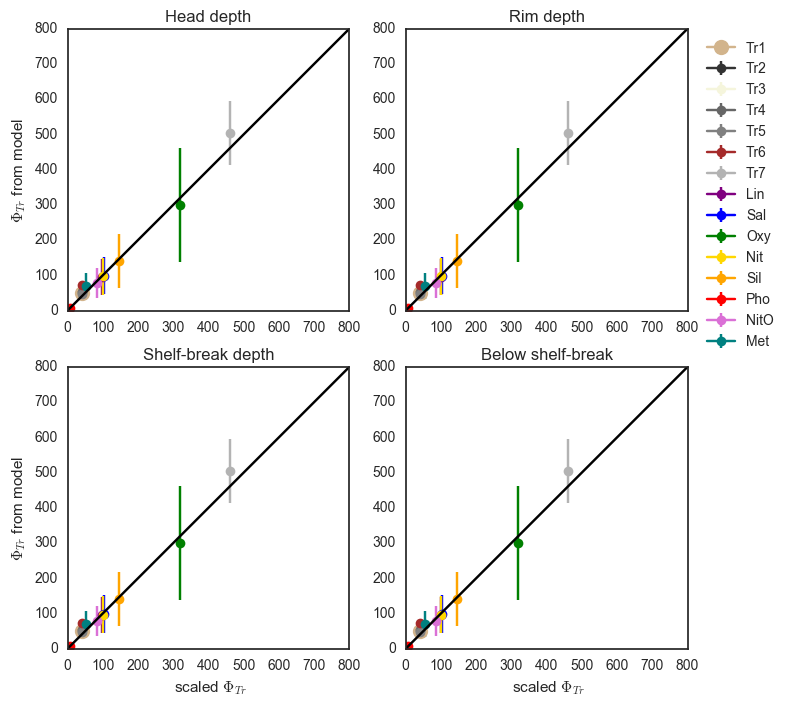

In [69]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

print (" ".join(['Tracer','PhiTrErr_hd (%)', 'PhiTrErr_rim (%)','PhiTrErr_sb (%)','PhiTrErr_ bel(%)',
                  '-dTr0 hd','-dTr0 rim','-dTr0 sb','-dTr0 bel','-dTr model']))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz,
                                                                          Par_inidTrdz_head,
                                                                          Par_inidTrdz_rim,
                                                                          Par_inidTrdz_below,
                                                                          Par_TrSB,Par_maxTr,
                                                                          labels_Para,colours_Para, sizes_Para):
    scaPhiTr_hd, CC = scale_PhiTr_Co(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC = scale_PhiTr_Co(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC = scale_PhiTr_Co(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC = scale_PhiTr_Co(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    modPhiTr, modPhiTr_std = model_PhiTr(dfLWR[TrMass], times)
    
    ax1.errorbar(scaPhiTr_hd/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax2.errorbar(scaPhiTr_rm/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax3.errorbar(scaPhiTr_sb/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax4.errorbar(scaPhiTr_bl/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    
    err_hd = scaPhiTr_hd/modPhiTr
    err_rm = scaPhiTr_rm/modPhiTr
    err_sb = scaPhiTr_sb/modPhiTr
    err_bl = scaPhiTr_bl/modPhiTr
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

for TrMass, dTr0, dTr0head, dTr0rim, dTr0below, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,
                                                                      Bar_inidTrdz_head,
                                                                      Bar_inidTrdz_rim,
                                                                      Bar_inidTrdz_below,
                                                                      Bar_TrSB,Bar_maxTr,
                                                                      labels_Bark,colours_Bark):
    
    scaPhiTr_hd, CC = scale_PhiTr_Co(dTr0head, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_rm, CC = scale_PhiTr_Co(dTr0rim, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_sb, CC = scale_PhiTr_Co(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    scaPhiTr_bl, CC = scale_PhiTr_Co(dTr0below, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    
    modPhiTr, modPhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr_hd/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax2.errorbar(scaPhiTr_rm/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax3.errorbar(scaPhiTr_sb/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    ax4.errorbar(scaPhiTr_bl/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    
    err_hd = scaPhiTr_hd/modPhiTr
    err_rm = scaPhiTr_rm/modPhiTr
    err_sb = scaPhiTr_sb/modPhiTr
    err_bl = scaPhiTr_bl/modPhiTr
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.3f\t%1.3f\t%1.3f\t\t%1.3f\t%1.3f\t%1.3f\t%1.3f' %
                                    (abs(1-err_hd)*100,abs(1-err_rm)*100,abs(1-err_sb)*100,abs(1-err_bl)*100,
                                   -dTr0head,-dTr0rim, -dTr0,-dTr0below)]))

ax3.set_xlabel(r' scaled $\Phi_{Tr}$')
ax4.set_xlabel(r' scaled $\Phi_{Tr}$')
ax1.set_ylabel(r'$\Phi_{Tr}$ from model')
ax3.set_ylabel(r'$\Phi_{Tr}$ from model')

ax3.set_title('Shelf-break depth')
ax1.set_title('Head depth')
ax2.set_title('Rim depth')
ax4.set_title('Below shelf-break')
ax1.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax2.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax3.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')
ax4.plot(np.linspace(0,800,50),np.linspace(0,800,50),'-k')

#ax1.set_xlim(-2,1.5)
#ax2.set_xlim(-2,1.5)
#ax3.set_xlim(-2,1.5)
#ax4.set_xlim(-2,1.5)

ax2.legend(bbox_to_anchor=(1.35,1),ncol=1, columnspacing=0.1)

The scaling is doing so bad, that just using $\Phi*C_{sb}$ is better than any scaling :(

### Choose the correct initial gradient 

I think I'm not using the correct initial gradient and that I am not scaling the right gradient, either. I want to scalue the gradient at the region where the maximum squeezing happens. The depth at which the maximum squeezing happens may vary depending on the profile and dynamical parameters but is always happens below head depth, as shown in the plots below.

Normalized by concetration at head depth 


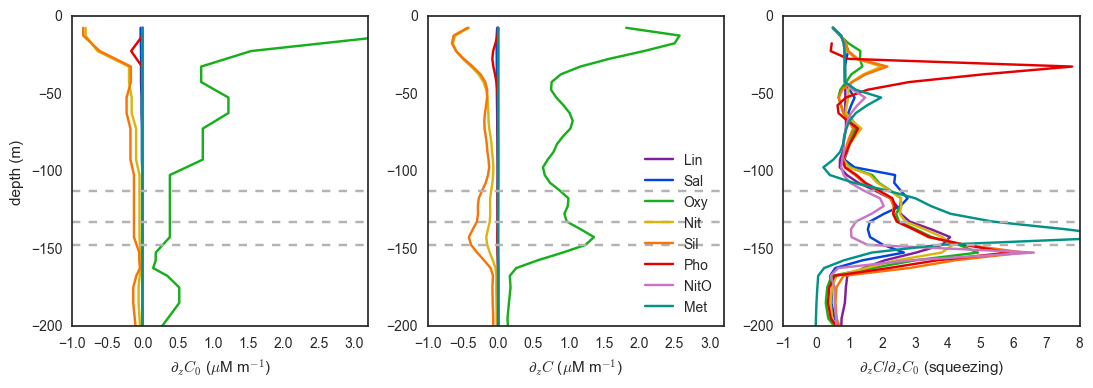

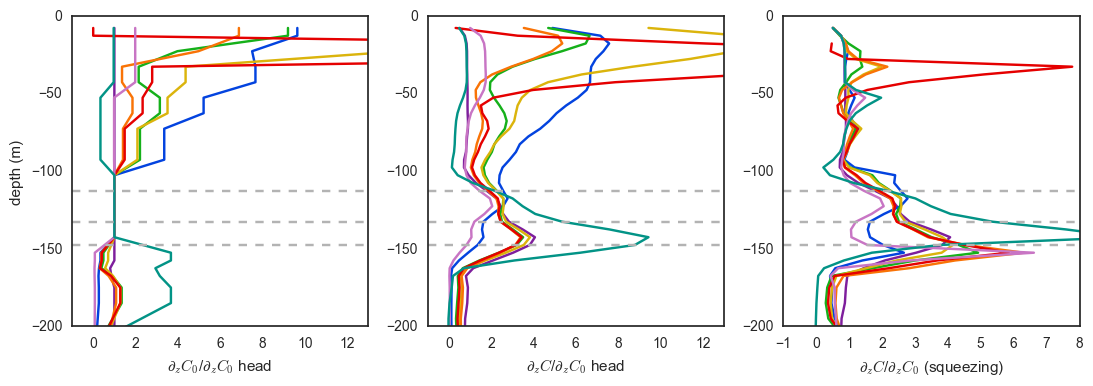

In [70]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))
fig2, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(13,4))

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

ind = 22 # head depth
record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    mean_profile = np.mean(np.vstack((np.array(df[keys[0]]),np.array(df[keys[1]]),
                                      np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0)      
    if tracer == 'Tr07' or tracer =='Tr08':
        ax2.plot(mean_profile/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot(mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    else:
        ax2.plot(mean_profile,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot( mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    if tracer == 'Tr07' or tracer =='Tr08':
        ax1.plot( df[key0]/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        
    else:
        ax1.plot( df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    
    ax3.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    ax6.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    ii=ii+1
  
ax1.set_ylim(-200,0)
ax2.set_ylim(-200,0)
ax2.set_xlim(-1,3.2)
ax1.set_xlim(-1,3.2)
ax3.set_ylim(-200,0)
ax4.set_xlim(-1,13)
ax4.set_ylim(-200,0)
ax5.set_xlim(-1,13)
ax5.set_ylim(-200,0)
ax6.set_ylim(-200,0)
ax3.set_xlim(-1,8)
ax6.set_xlim(-1,8)

ax2.set_xlabel(r'$\partial_z C$ ($\mu$M m$^{-1}$)')
ax3.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax1.set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')
ax1.set_ylabel(r'depth (m)')

ax5.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ head')
ax6.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax4.set_xlabel(r'$\partial_z C_0$/$\partial_z C_0$ head ')
ax4.set_ylabel(r'depth (m)')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axhline(depth[29], color='0.7', linestyle='--')
    ax.axhline(depth[26], color='0.7', linestyle='--')
    ax.axhline(depth[22], color='0.7', linestyle='--')

ax2.legend(loc=0)

print('Normalized by concetration at head depth ')

Normalized by concetration at rim depth 


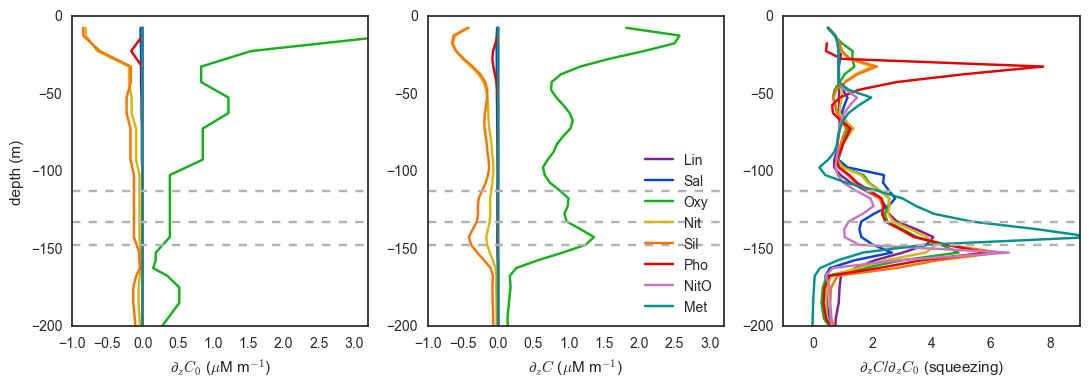

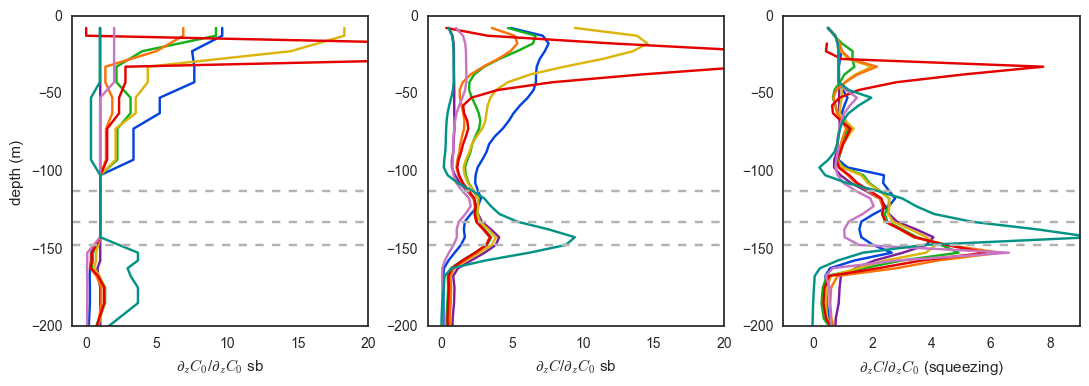

In [71]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))
fig2, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(13,4))

ind = 26 # rim
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    mean_profile = np.mean(np.vstack((np.array(df[keys[0]]),np.array(df[keys[1]]),
                                      np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0)      
    if tracer == 'Tr07' or tracer =='Tr08':
        ax2.plot(mean_profile/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot(mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    else:
        ax2.plot(mean_profile,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot(mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    if tracer == 'Tr07' or tracer =='Tr08':
        ax1.plot(df[key0]/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot(df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        
    else:
        ax1.plot(df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot(df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    
    ax3.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    ax6.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    ii=ii+1
  
ax1.set_ylim(-200,0)
ax2.set_ylim(-200,0)
ax2.set_xlim(-1,3.2)
ax1.set_xlim(-1,3.2)
ax3.set_ylim(-200,0)
ax4.set_xlim(-1,20)
ax4.set_ylim(-200,0)
ax5.set_xlim(-1,20)
ax5.set_ylim(-200,0)
ax6.set_ylim(-200,0)
ax3.set_xlim(-1,9)
ax6.set_xlim(-1,9)

ax2.set_xlabel(r'$\partial_z C$ ($\mu$M m$^{-1}$)')
ax3.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax1.set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')
ax1.set_ylabel(r'depth (m)')

ax5.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ sb')
ax6.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax4.set_xlabel(r'$\partial_z C_0$/$\partial_z C_0$ sb ')
ax4.set_ylabel(r'depth (m)')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axhline(depth[29], color='0.7', linestyle='--')
    ax.axhline(depth[26], color='0.7', linestyle='--')
    ax.axhline(depth[22], color='0.7', linestyle='--')

ax2.legend(loc=0)
print('Normalized by concetration at rim depth ')

Normalized by concetration at shelf-break depth 


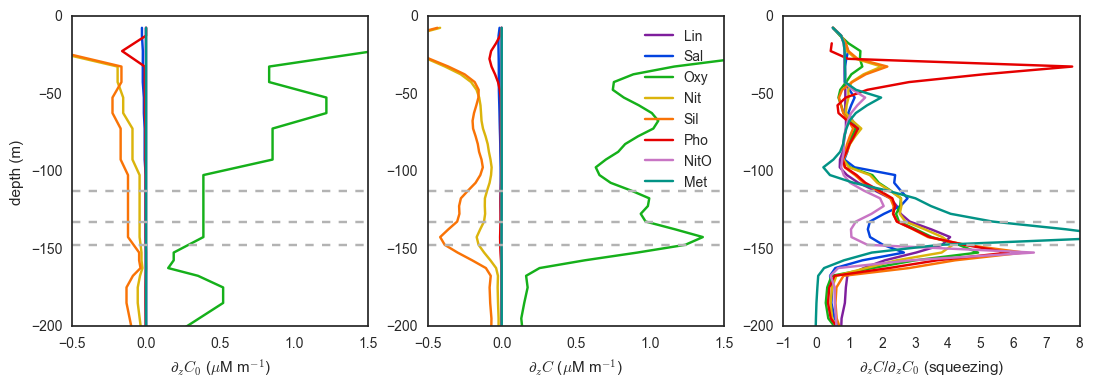

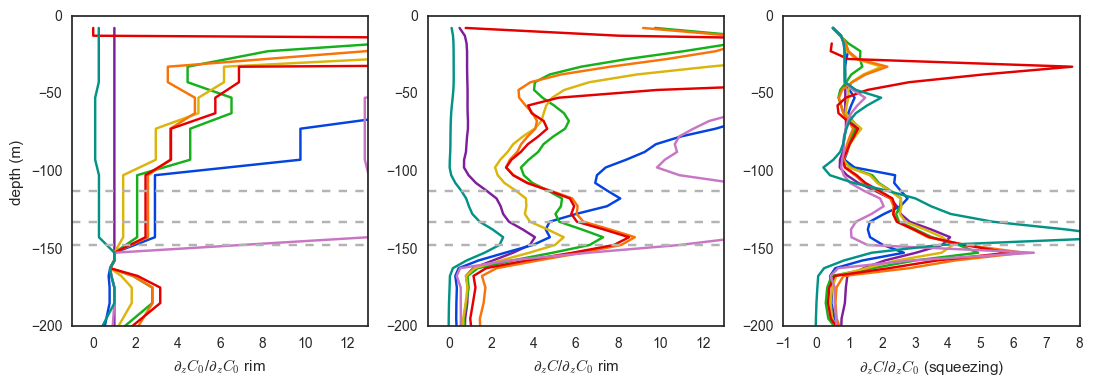

In [72]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))
fig2, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(13,4))

ind = 29 # shelf break depth
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    mean_profile = np.mean(np.vstack((np.array(df[keys[0]]),np.array(df[keys[1]]),
                                      np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0)      
    if tracer == 'Tr07' or tracer =='Tr08':
        ax2.plot(mean_profile/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot(mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    else:
        ax2.plot(mean_profile,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot( mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    if tracer == 'Tr07' or tracer =='Tr08':
        ax1.plot( df[key0]/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        
    else:
        ax1.plot( df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    
    ax3.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    ax6.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    ii=ii+1
  
ax1.set_ylim(-200,0)
ax2.set_ylim(-200,0)
ax2.set_xlim(-0.5,1.5)
ax1.set_xlim(-0.5,1.5)
ax3.set_ylim(-200,0)
ax4.set_xlim(-1,13)
ax4.set_ylim(-200,0)
ax5.set_xlim(-1,13)
ax5.set_ylim(-200,0)
ax6.set_ylim(-200,0)
ax3.set_xlim(-1,8)
ax6.set_xlim(-1,8)

ax2.set_xlabel(r'$\partial_z C$ ($\mu$M m$^{-1}$)')
ax3.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax1.set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')
ax1.set_ylabel(r'depth (m)')

ax5.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ rim')
ax6.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax4.set_xlabel(r'$\partial_z C_0$/$\partial_z C_0$ rim ')
ax4.set_ylabel(r'depth (m)')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axhline(depth[29], color='0.7', linestyle='--')
    ax.axhline(depth[26], color='0.7', linestyle='--')
    ax.axhline(depth[22], color='0.7', linestyle='--')

ax2.legend(loc=0)
print('Normalized by concetration at shelf-break depth ')

Zoom into plots normalized by concentration at shelf break depth 


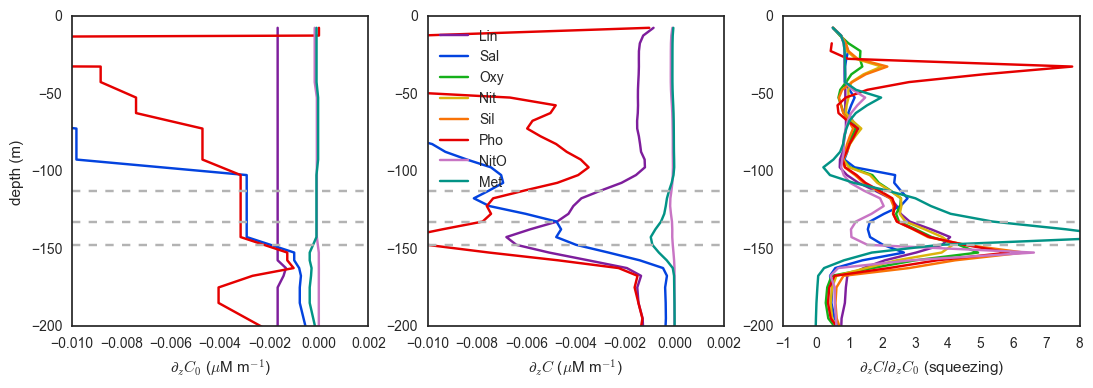

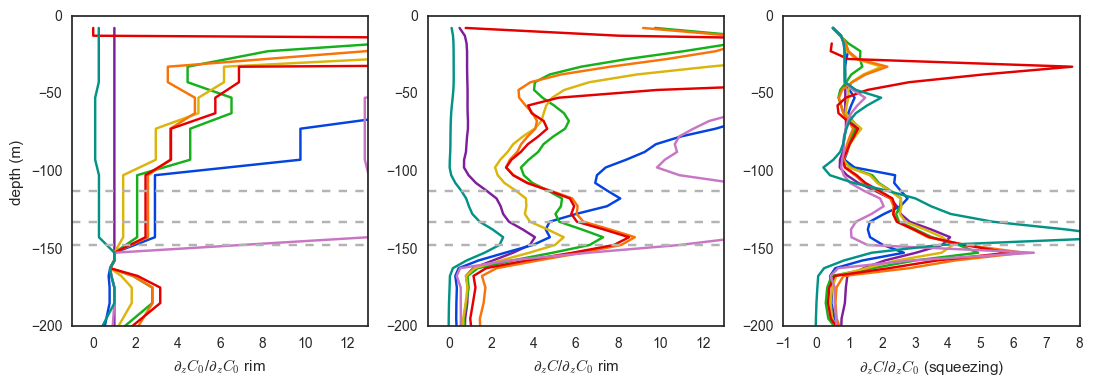

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))
fig2, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(13,4))

ind = 29 # rim depth
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    mean_profile = np.mean(np.vstack((np.array(df[keys[0]]),np.array(df[keys[1]]),
                                      np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0)      
    if tracer == 'Tr07' or tracer =='Tr08':
        ax2.plot(mean_profile/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot(mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    else:
        ax2.plot(mean_profile,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax5.plot( mean_profile/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    if tracer == 'Tr07' or tracer =='Tr08':
        ax1.plot( df[key0]/1000,depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        
    else:
        ax1.plot( df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
        ax4.plot( df[key0]/df[key0][ind],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    
    ax3.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
    ax6.plot(mean_profile/df[key0],depth[1:-1], color=sns.xkcd_rgb[colours_Bark[ii]], label = labels_Bark[ii])
   
    ii=ii+1
  
ax1.set_ylim(-200,0)
ax2.set_ylim(-200,0)
ax2.set_xlim(-0.01,0.002)
ax1.set_xlim(-0.01,0.002)
ax3.set_ylim(-200,0)
ax4.set_xlim(-1,13)
ax4.set_ylim(-200,0)
ax5.set_xlim(-1,13)
ax5.set_ylim(-200,0)
ax6.set_ylim(-200,0)
ax3.set_xlim(-1,8)
ax6.set_xlim(-1,8)

ax2.set_xlabel(r'$\partial_z C$ ($\mu$M m$^{-1}$)')
ax3.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax1.set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')
ax1.set_ylabel(r'depth (m)')

ax5.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ rim')
ax6.set_xlabel(r'$\partial_z C$/$\partial_z C_0$ (squeezing)')
ax4.set_xlabel(r'$\partial_z C_0$/$\partial_z C_0$ rim ')
ax4.set_ylabel(r'depth (m)')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axhline(depth[29], color='0.7', linestyle='--')
    ax.axhline(depth[26], color='0.7', linestyle='--')
    ax.axhline(depth[22], color='0.7', linestyle='--')

ax2.legend(loc=0)
print('Zoom into plots normalized by concentration at shelf break depth ')

Left: Initial gradient profiles (normalized in bottom panel by Co at rim, head or sb, depending on the plot). Centre: Mean gradient profiles during advective phase. Right: Maximum squeezing occurs below head depth and methane has the maximum squeezing of all. 

**The estimate of $\partial_zC$ that we want to scale is the one that corresponds to the max squeezing below head depth.**

## Scale max gradient below head depth

First we need to find what is the appropriate scale for the initial gradient. Which one is the one that is proportional to the squeezed gradient? (ie. at the rim, head or shelf-break depths? or below?)

In [74]:
dTrdz_mod = np.empty(8)
inidTrdz_sb = np.empty(8)
inidTrdz_head = np.empty(8)
inidTrdz_rim = np.empty(8)
inidTrdz_below = np.empty(8)

dTrdz_std = np.empty(8)

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    if tracer == 'Tr07' or tracer =='Tr08': # methane and nitrous oxide are in nmol/l, not mu mol/l
        mean_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)/1000 
        inidTrdz_sb[ii] = df[key0][29]/1000
        inidTrdz_head[ii] = df[key0][22]/1000
        inidTrdz_rim[ii] = df[key0][26]/1000
        inidTrdz_below[ii] = df[key0][33]/1000

        std_profile = np.std(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)/1000
    else:
        mean_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)
        inidTrdz_sb[ii] = df[key0][29]
        inidTrdz_head[ii] = df[key0][22]
        inidTrdz_rim[ii] = df[key0][26]
        inidTrdz_below[ii] = df[key0][33]
        std_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                       np.array(df[keys[2]]),np.array(df[keys[3]]),
                                       np.array(df[keys[4]]))), axis=0)
    maxind = np.argmax(abs(mean_profile[22:33])) # find index of max in absolute value
    
    dTrdz_mod[ii] = mean_profile[22+maxind]
    dTrdz_std[ii] = std_profile[22+maxind]
    
    ii = ii+1
    

Lin, head error -0.588, rim error -0.588, sb error -0.588,below error -0.588
Sal, head error -0.219, rim error -0.219, sb error -2.555,below error -3.587
Oxy, head error -0.362, rim error -0.362, sb error -1.826,below error -0.012
Nit, head error -0.490, rim error -0.490, sb error -1.110,below error -0.160
Sil, head error -0.324, rim error -0.324, sb error -2.428,below error -0.223
Pho, head error -0.337, rim error -0.337, sb error -2.304,below error -0.043
NitO, head error 0.156, rim error 0.156, sb error -9.986,below error -9.986
Met, head error -2.644, rim error -2.644, sb error 0.008,below error 0.008


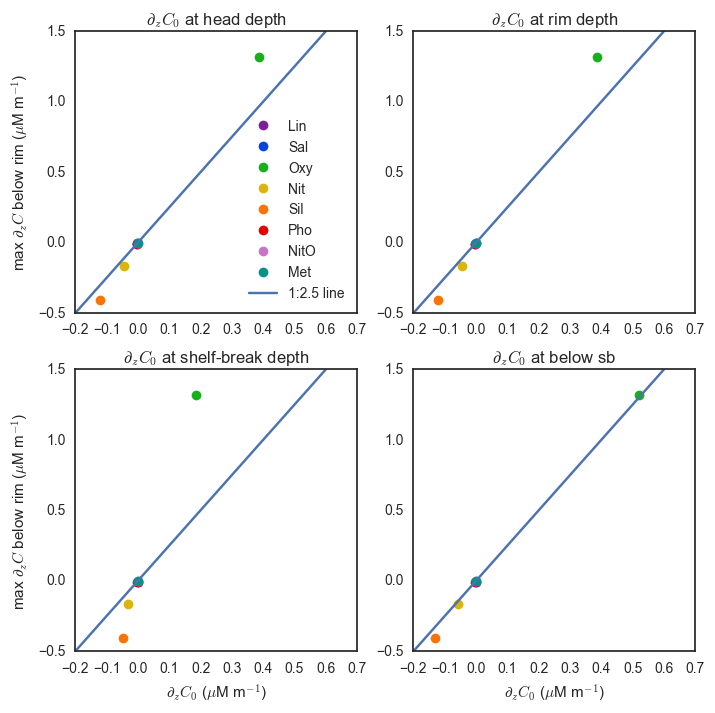

In [75]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

for col, lab, ii in zip(colours_Bark, labels_Bark, range(len(colours_Bark))):
    
    ax[0,0].plot(inidTrdz_head[ii],dTrdz_mod[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[0,1].plot(inidTrdz_rim[ii],dTrdz_mod[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,0].plot(inidTrdz_sb[ii],dTrdz_mod[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,1].plot(inidTrdz_below[ii],dTrdz_mod[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    print('%s, head error %1.3f, rim error %1.3f, sb error %1.3f,below error %1.3f' %(
            labels_Bark[ii], 
            (1.0-(dTrdz_mod[ii]/(2.5*inidTrdz_head[ii]))),
            (1.0-(dTrdz_mod[ii]/(2.5*inidTrdz_rim[ii]))),
            (1.0-(dTrdz_mod[ii]/(2.5*inidTrdz_sb[ii]))),
            (1.0-(dTrdz_mod[ii]/(2.5*inidTrdz_below[ii])))))

ax[0,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20), label= '1:2.5 line')    
ax[0,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
ax[1,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
ax[1,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))   

ax[0,0].legend(loc=0)

ax[0,0].set_ylabel(r'max $\partial_z C$ below rim ($\mu$M m$^{-1}$)')
ax[1,0].set_ylabel(r'max $\partial_z C$ below rim ($\mu$M m$^{-1}$)')

ax[1,0].set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')
ax[1,1].set_xlabel(r'$\partial_z C_0$ ($\mu$M m$^{-1}$)')

ax[0,0].set_title(r'$\partial_z C_0$ at head depth')
ax[0,1].set_title(r'$\partial_z C_0$ at rim depth')
ax[1,0].set_title(r'$\partial_z C_0$ at shelf-break depth')
ax[1,1].set_title(r'$\partial_z C_0$ at below sb')




So, it looks like, with a slope of 2.5 I can relate the max gradient below the rim and the initial gradient below shelf break depth 22% and 0.1%. I think that is the squeezing I need to scale. It is not good for linear (60% error) and terrible for nitrous oxide and salinity (1000% and 360%).

### Rescale squeezing

I went back and re-scale the tracer gradient (as the max tracer gradient below the head), using as initial tracer gradient scale the grad below shelf break depth (at index 33). (See this notebook: http://localhost:8888/notebooks/scaling/scale_TrGradient_within_canyon.ipynb# )

$$\frac{\partial_z C}{\partial_z C_0}=3.97(1+\frac{Z+Z_{dif}}{H_h})-2.33$$

Lin error 0.005
Sal error -1.874
Oxy error 0.366
Nit error 0.274
Sil error 0.234
Pho error 0.346
NitO error -5.882
Met error 0.378


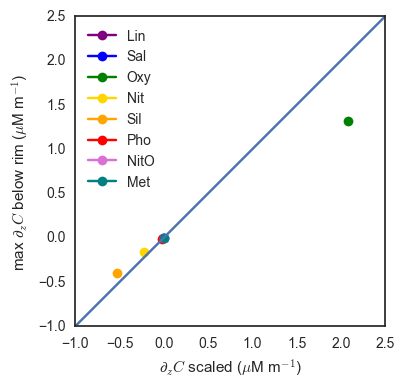

In [76]:
fig,(ax1) = plt.subplots(1,1,figsize=(4,4))

for dTr0below, lab, col,ii in zip(inidTrdz_below,labels_Bark,colours_Bark, np.arange(len(colours_Bark))):
    scaGrad = dTrdz_below(dTr0below, Hs, Z(f,U,R,L,No), Zdif(t,kv,kbg), Hh)
    ax1.plot(scaGrad, dTrdz_mod[ii], color=col, label=lab, marker='o',markersize=ms)
    print('%s error %1.3f' %(labels_Bark[ii], (1.0-(dTrdz_mod[ii]/scaGrad))))
            
ax1.plot(np.linspace(-1,2.5,20),np.linspace(-1,2.5,20))

ax1.set_ylabel(r'max $\partial_z C$ below rim ($\mu$M m$^{-1}$)')
ax1.set_xlabel(r'$\partial_z C$ scaled ($\mu$M m$^{-1}$)')
ax1.legend(loc=0)

It works within 30% but it is still bad for nitrous-oxide and salinity (that comes from the previous step).

### Rescale concentration

I re-fitted the concentration to the mean concetration between rim and shelf-break depth of the mean profile during the advective phase and got the following relation:

$$\frac{\bar{C}}{C_0} = -0.01\partial_zC(\frac{H_{rim}+H_{h}}{2})+1.03$$

where $C_0$ is the initial concentration at rim depth (it can be at shelf break depth too, probably). Also I could also fit into H_rim+Hsb?

In [77]:
Conc_mod = np.empty(8)
Conc_std = np.empty(8)
iniConc_rim = np.empty(8)
iniConc_sb = np.empty(8)
iniConc_head = np.empty(8)
C_head =  np.empty(8)
C_rim =  np.empty(8)
C_sb =  np.empty(8)
C_below =  np.empty(8)

keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

ii=0
record = recordsTr[0]
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    
    if tracer == 'Tr07' or tracer =='Tr08': # methane and nitrous oxide are in nmol/l, not mu mol/l
        mean_profile = np.mean(np.vstack((np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0)/1000 
        iniConc_rim[ii] = df[key0][26]/1000
        iniConc_sb[ii] = df[key0][30]/1000
        iniConc_head[ii] = df[key0][22]/1000
         
        std_profile = np.std(np.vstack((np.array(df[keys[2]]),np.array(df[keys[3]]),
                                    np.array(df[keys[4]]))), axis=0)/1000
    else:
        mean_profile = np.mean(np.vstack((np.array(df[keys[2]]),np.array(df[keys[3]]),
                                      np.array(df[keys[4]]))), axis=0) 
        iniConc_rim[ii] = df[key0][26]
        iniConc_sb[ii] = df[key0][30]
        iniConc_head[ii] = df[key0][22]
        std_profile = np.std(np.vstack((np.array(df[keys[2]]),np.array(df[keys[3]]),
                                    np.array(df[keys[4]]))), axis=0)
    C_head[ii] =mean_profile[22]
    C_rim[ii] =mean_profile[26]
    C_sb[ii] =mean_profile[30]
    C_below[ii] = np.mean(mean_profile[26:33])
       
    Conc_mod[ii] = np.mean(mean_profile[26:30])
    Conc_std[ii] = np.std(mean_profile[26:30])
    
    ii = ii+1


Lin error 0.018
Sal error 0.024
Oxy error 0.781
Nit error -0.487
Sil error -2.786
Pho error -0.049
NitO error -0.002
Met error -0.699


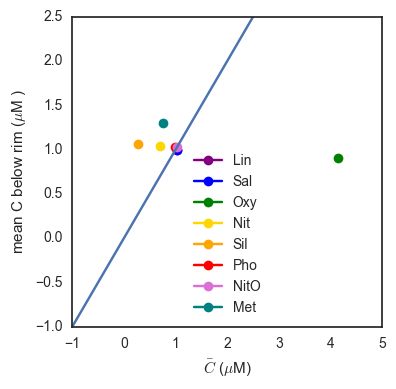

In [81]:
fig,(ax1) = plt.subplots(1,1,figsize=(4,4))

for dTr0below, iniC_rim, lab, col,ii in zip(inidTrdz_below, iniConc_rim, labels_Bark,colours_Bark, 
                                           np.arange(len(colours_Bark))):
    scaGrad = dTrdz_below(dTr0below, Hs, Z(f,U,R,L,No), Zdif(t,kv,kbg), Hh)
    scaConc = Cbar_below(scaGrad, Hs, Hr, iniC_rim)
    ax1.plot(scaConc/C_rim[ii], Conc_mod[ii]/C_rim[ii], color=col, label=lab, marker='o',markersize=ms)
    print('%s error %1.3f' %(labels_Bark[ii], (1.0-(Conc_mod[ii]/scaConc))))
            
ax1.plot(np.linspace(-1,2.5,20),np.linspace(-1,2.5,20))

ax1.set_ylabel(r'mean C below rim ($\mu$M )')
ax1.set_xlabel(r'$\bar{C}$ ($\mu$M)')
ax1.legend(loc=0)

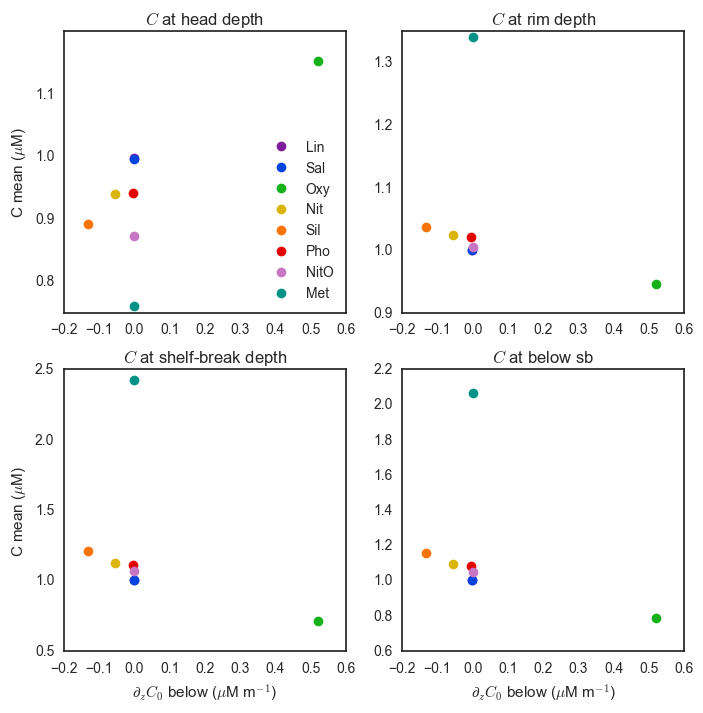

In [82]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

for col, lab, ii in zip(colours_Bark, labels_Bark, range(len(colours_Bark))):
    
    ax[0,0].plot(inidTrdz_below[ii],C_head[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[0,1].plot(inidTrdz_below[ii],C_rim[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,0].plot(inidTrdz_below[ii],C_sb[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,1].plot(inidTrdz_below[ii],C_below[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    
#ax[0,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20), label= '1:2.5 line')    
#ax[0,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
#ax[1,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
#ax[1,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))   

ax[0,0].legend(loc=0)

ax[0,0].set_ylabel(r'C mean ($\mu$M)')
ax[1,0].set_ylabel(r'C mean ($\mu$M)')

ax[1,0].set_xlabel(r'$\partial_z C_0$ below ($\mu$M m$^{-1}$)')
ax[1,1].set_xlabel(r'$\partial_z C_0$ below ($\mu$M m$^{-1}$)')

ax[0,0].set_title(r'$C$ at head depth')
ax[0,1].set_title(r'$C$ at rim depth')
ax[1,0].set_title(r'$C$ at shelf-break depth')
ax[1,1].set_title(r'$C$ at below sb')

#ax[0,0].set_xlim(0,140)
#ax[0,1].set_xlim(0,140)
#ax[1,0].set_xlim(0,140)
#ax[1,1].set_xlim(0,140)


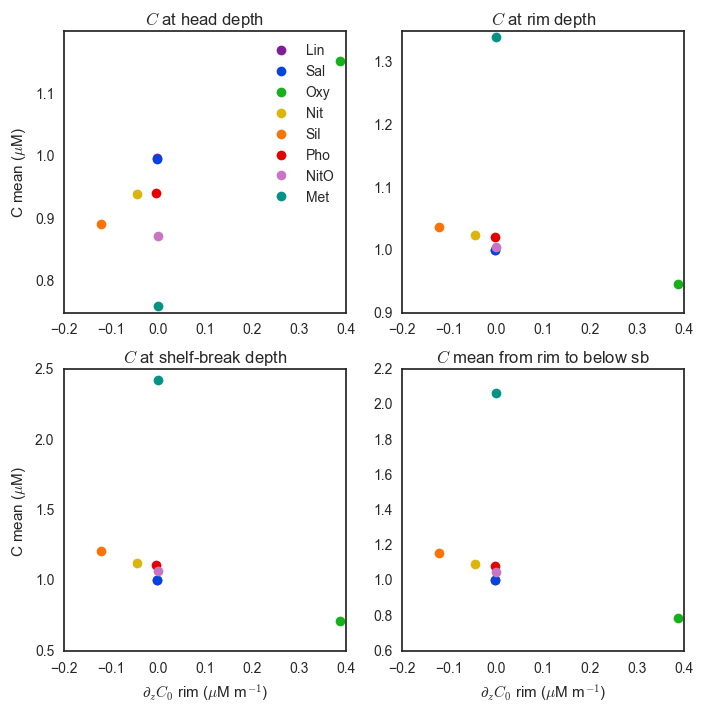

In [80]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

for col, lab, ii in zip(colours_Bark, labels_Bark, range(len(colours_Bark))):
    
    ax[0,0].plot(inidTrdz_rim[ii],C_head[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[0,1].plot(inidTrdz_rim[ii],C_rim[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,0].plot(inidTrdz_rim[ii],C_sb[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    ax[1,1].plot(inidTrdz_rim[ii],C_below[ii]/iniConc_rim[ii],'o', color = sns.xkcd_rgb[col], label=lab)
    
#ax[0,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20), label= '1:2.5 line')    
#ax[0,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
#ax[1,0].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))    
#ax[1,1].plot(np.linspace(-0.2, 0.6, 20),2.5*np.linspace(-0.2, 0.6, 20))   

ax[0,0].legend(loc=0)

ax[0,0].set_ylabel(r'C mean ($\mu$M)')
ax[1,0].set_ylabel(r'C mean ($\mu$M)')

ax[1,0].set_xlabel(r'$\partial_z C_0$ rim ($\mu$M m$^{-1}$)')
ax[1,1].set_xlabel(r'$\partial_z C_0$ rim ($\mu$M m$^{-1}$)')

ax[0,0].set_title(r'$C$ at head depth')
ax[0,1].set_title(r'$C$ at rim depth')
ax[1,0].set_title(r'$C$ at shelf-break depth')
ax[1,1].set_title(r'$C$ mean from rim to below sb')

#ax[0,0].set_xlim(0,140)
#ax[0,1].set_xlim(0,140)
#ax[1,0].set_xlim(0,140)
#ax[1,1].set_xlim(0,140)
